In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from icglm.iclamp import IClamp
from icglm.kernels.rect import KernelRect
from icglm.kernels.rect2d import KernelRect2d
from icglm.kernels.fun import KernelFun
from icglm.models.gqm import GQM
from icglm.plot.decoding import DecodingPlotter
from icglm.plot.fit import GLMPlotter
from icglm.processes import OUProcess
from icglm.spiketrain import SpikeTrain
# from icglm.plot.spiketrain import SpikeTrainsPlotter

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
a = np.random.rand(10, 2, 2) > 0.5

In [46]:
aux

(array([0, 0, 1, 1]), array([0, 1, 0, 1]))

In [44]:
aux = np.where(np.any(a, 0))
# a[:5, aux].shape
a[(slice(None, 5),) + aux].shape

(5, 4)

In [83]:
a[(slice(None, 5),) + (0, 0)]

array([ True,  True, False, False, False])

In [78]:
np.where(a[:5][(0, 0)])
# np.where(a[(0, 0)][:5])

(array([0]),)

In [27]:
# aux = np.where(a)
# for ii, k in enumerate(aux[0]):
#     index = tuple([slice(k, None)] + [aux[dim][ii] for dim in range(1, len(aux))])
#     print(index)

In [122]:
from icglm.utils.time import get_dt

def sample1(self, t, stim, stim_h=0, full=False):

    u0, kappa = self.u0, self.kappa
    dt = get_dt(t)

    if stim.ndim == 1:
        shape = (len(t), 1)
        stim = stim.reshape(len(t), 1)
    else:
        shape = stim.shape

    r = np.zeros(shape) * np.nan
    eta_conv = np.zeros(shape)
    quad_eta_conv = np.zeros(shape)
    mask_spk = np.zeros(shape, dtype=bool)
    arg_spikes = ([], ) * stim.ndim

    kappa_conv = self.kappa.convolve_continuous(t, stim - stim_h) + stim_h * self.kappa.area(dt=dt)
    quad_kappa_conv = self.quad_kappa.convolve_continuous(t, stim)

    j = 0
    while j < len(t):

        r[j, ...] = np.exp(kappa_conv[j, ...] + quad_kappa_conv[j, ...] - eta_conv[j, ...] - quad_eta_conv[j, ...] - u0)

        p_spk = 1. - np.exp(-r[j, ...] * dt)
        aux = np.random.rand(*shape[1:])

        mask_spk[j, ...] = p_spk > aux

        if np.any(mask_spk[j, ...]) and j < len(t) - 1:
            eta_conv[j + 1:, mask_spk[j, ...]] += self.eta.interpolate(t[j + 1:] - t[j + 1])[:, None]
            for aux in np.where(np.any(mask_spk[:j + 1, ...], 0)):
                arg_previous_spikes = np.where(mask_spk[:j + 1, aux])
                for kk in arg_previous_spikes[0]:
                    if kk == j:
                        quad_eta_conv[j + 1:, aux] += np.moveaxis(
                            np.diagonal(self.quad_eta.interpolate(t[j + 1:] - t[kk + 1], t[j + 1:] - t[j + 1])),
                            -1, 0)[:, None]
                    else:
                        quad_eta_conv[j + 1:, aux] += 2 * np.moveaxis(np.diagonal(self.quad_eta.interpolate(t[j + 1:] - t[kk + 1], t[j + 1:] - t[j + 1])),
                                                -1, 0)[:, None]
        j += 1

    v = kappa_conv + quad_kappa_conv - eta_conv - quad_eta_conv - u0
    if full:
        return kappa_conv, quad_kappa_conv, eta_conv, quad_eta_conv, v, r, mask_spk
    else:
        return v, r, mask_spk
    
def sample2(self, t, stim, stim_h=0, full=False):

    u0, kappa = self.u0, self.kappa
    dt = get_dt(t)

    if stim.ndim == 1:
        shape = (len(t), 1)
        stim = stim.reshape(len(t), 1)
    else:
        shape = stim.shape

    r = np.zeros(shape) * np.nan
    eta_conv = np.zeros(shape)
    quad_eta_conv = np.zeros(shape)
    mask_spk = np.zeros(shape, dtype=bool)
#     arg_spikes = ([], ) * stim.ndim
    support = int(np.ceil(self.quad_eta.support_x[1] / dt))
    print(support)

    kappa_conv = self.kappa.convolve_continuous(t, stim - stim_h) + stim_h * self.kappa.area(dt=dt)
    quad_kappa_conv = self.quad_kappa.convolve_continuous(t, stim)

    j = 0
    while j < len(t):

        r[j, ...] = np.exp(kappa_conv[j, ...] + quad_kappa_conv[j, ...] - eta_conv[j, ...] - quad_eta_conv[j, ...] - u0)

        p_spk = 1. - np.exp(-r[j, ...] * dt)
        aux = np.random.rand(*shape[1:])

        mask_spk[j, ...] = p_spk > aux

        if np.any(mask_spk[j, ...]) and j < len(t) - 1:
            eta_conv[j + 1:, mask_spk[j, ...]] += self.eta.interpolate(t[j + 1:] - t[j + 1])[:, None]
            quad_eta_conv[j + 1:, mask_spk[j, ...]] += np.moveaxis(np.diagonal(self.quad_eta.interpolate(t[j + 1:] - t[j + 1], 
                                                                                                         t[j + 1:] - t[j + 1])), -1, 0)[:, None]
#             idx = np.where(np.any(mask_spk[max(0, j - support):j, ...], 0) & mask_spk[j, ...])
            idx = np.where(np.any(mask_spk[:j, ...], 0) & mask_spk[j, ...])
            for ii in range(len(idx[0])):
                aux = (slice(max(0, j - support - 1), j),) + tuple([idx[dim][ii] for dim in range(len(idx))])
                aux2 = (slice(j + 1, None),) + tuple([idx[dim][ii] for dim in range(len(idx))])
                arg_previous_spikes = np.where(mask_spk[aux])
                for kk in arg_previous_spikes[0]:
                    _k = kk + max(0, j - support - 1)
                    quad_eta_conv[aux2] += 2 * np.moveaxis(np.diagonal(self.quad_eta.interpolate(t[j + 1:] - t[_k + 1], 
                                                                                    t[j + 1:] - t[j + 1])), -1, 0)#[:, None]
        j += 1

    v = kappa_conv + quad_kappa_conv - eta_conv - quad_eta_conv - u0
    if full:
        return kappa_conv, quad_kappa_conv, eta_conv, quad_eta_conv, v, r, mask_spk
    else:
        return v, r, mask_spk
    
GQM.sample1 = sample1
GQM.sample2 = sample2
GQM.sample3 = sample3

80
[47] [0.0392]


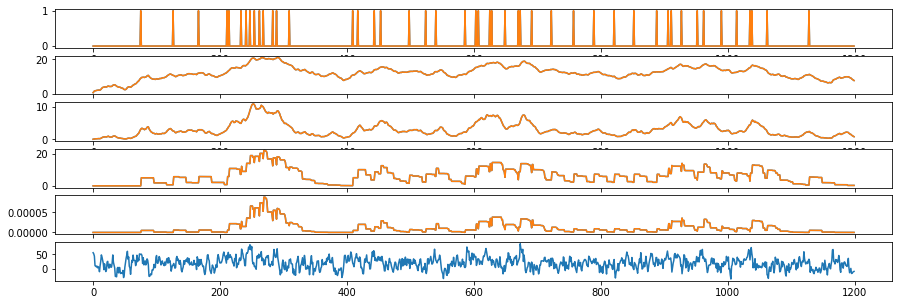

In [123]:
dt = 1
t = np.arange(0, 1200, dt)
stim = OUProcess(mu=20, sd=20, tau=3).sample(t, seed=3, shape=(1,))

kappa = KernelRect.exponential(tf=375, dt=25, tau=50, A=1e-2)
eta = KernelRect.exponential(tf=160, dt=20, tau=20, A=5)
tbins_Kappa_ = kappa.tbins[:5]
tbins_Kappa = np.meshgrid(tbins_Kappa_, tbins_Kappa_)
coefs_Kappa0 = np.exp(-(tbins_Kappa[0][:-1, :-1]**2 + tbins_Kappa[1][:-1, :-1]**2)**.5 / 20) * 5e-6
tbins_Eta_ = eta.tbins[:5]
tbins_Eta = np.meshgrid(tbins_Eta_, tbins_Eta_)
coefs_Eta = np.exp(-(tbins_Eta[0][:-1, :-1]**2 + tbins_Eta[1][:-1, :-1]**2)**.5 / 20) * 1

gqm = GQM(u0=15, kappa=kappa, eta=eta, 
          quad_kappa=KernelRect2d(tbins_x=tbins_Kappa_, tbins_y=tbins_Kappa_, coefs=coefs_Kappa0), 
          quad_eta=KernelRect2d(tbins_x=tbins_Eta_, tbins_y=tbins_Eta_, coefs=coefs_Kappa0))

np.random.seed(0)
kappa_conv, quad_kappa_conv, eta_conv, quad_eta_conv, v, r, mask_spk = gqm.sample1(t, stim, full=True)
np.random.seed(0)
kappa_conv2, quad_kappa_conv2, eta_conv2, quad_eta_conv2, v2, r2, mask_spk2 = gqm.sample2(t, stim, full=True)

st = SpikeTrain(t, mask_spk)
print(np.sum(mask_spk, 0), np.sum(mask_spk, 0) / t[-1])

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(figsize=(15, 5), nrows=6)
ax1.plot(t, mask_spk)
ax1.plot(t, mask_spk2)
ax2.plot(t, kappa_conv)
ax2.plot(t, kappa_conv2)
ax3.plot(t, quad_kappa_conv)
ax3.plot(t, quad_kappa_conv2)
ax4.plot(t, eta_conv)
ax4.plot(t, eta_conv2)
ax5.plot(t, quad_eta_conv)
ax5.plot(t, quad_eta_conv2)
ax6.plot(t, stim)